/home/mukundan/learning/face_algo/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mukundan/learning/face_algo/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


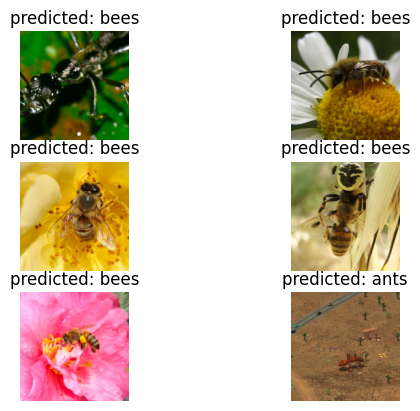

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Set up data transformations for validation
# We only need the validation transformations for inference.
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'hymenoptera_data'

# 2. Create validation dataset and dataloader
# We only need the validation set to get images for visualization.
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

# Get class names from the folder names in the training directory
class_names = val_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 3. Load the model architecture
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# 4. Load the saved model weights
# Ensure 'best_model.pth' is in the same directory.
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)


# 5. Define the visualization function
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')

                # Undo the normalization to display the image correctly
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show() # Show the plot and return
                    return
        model.train(mode=was_training)

# 6. Run the visualization
visualize_model(model)